In [1]:
library(ggplot2)
library(ggpubr)
library(aod)
library(ROCR)
library(survival)
library(survminer)


Attaching package: ‘survival’


The following object is masked from ‘package:aod’:

    rats




In [2]:
options(jupyter.plot_mimetypes = "image/png", dpi = 300)
options(repr.plot.width = 10, repr.plot.height = 5)

In [4]:
pheno <- read.csv('/mnt/stsi/stsi1/sfchen/191120_PRS_validator/analysis/aric_cad_pheno.csv')

pheno$ID <- as.character(pheno$SAMPLE_ID)
pheno$N <- length(pheno$ID)
data <- pheno[,c('ID','N','ISP12','AGISP12')]

for (int in 1:30){
    file <- read.csv(paste0('210729-V',int,'.tmp-PRS_1047343-aric_c1-ancestry_1-N_8264-chrALL.csv'))
    file <- rbind(file,read.csv(paste0('210729-V',int,'.tmp-PRS_1047343-aric_c1-ancestry_3-N_3-chrALL.csv')))
    file <- rbind(file,read.csv(paste0('210729-V',int,'.tmp-PRS_1047343-aric_c1-ancestry_5-N_508-chrALL.csv')))
    file <- rbind(file,read.csv(paste0('210729-V',int,'.tmp-PRS_1047343-aric_c1-ancestry_mixed-N_4284-chrALL.csv')))
    file$ID <- sapply(strsplit(file$X.sampleID,'_'),'[[',2)
    file$PRS <- file$sum_PRS / file$SNP_N
    file <- file[,c('ID','PRS')]
    names(file) <- c('ID',paste0('V',int,'_PRS'))
    data <- merge(data,file,by='ID')
}

data$ISP12 <- as.factor(data$ISP12)

In [5]:
offset = 4
for (i in 1:30) {
    data$std <- ( ( data[[i+offset]] - mean(data[[i+offset]] )) / sd(data[[i+offset]]) )
    colnames(data)[which(names(data) == "std")] <- paste0('V',i,'_PRS_std')
}

In [6]:
offset = 34
V_names = glue::glue('V{i}_PRS_std',i=1:30)
plots <- vector('list', 30)

for (i in 1:30) {
    plots[[i]] <- local({
        i <- i
        plot <- ggplot(data, aes_string(V_names[[i]], color = 'ISP12')) + 
        geom_vline(xintercept = 0, linetype = 'longdash') +
        geom_vline(xintercept = mean(data[data$ISP12==0,i+34]), linetype = 'longdash', color = '#F8766D') +
        geom_vline(xintercept = mean(data[data$ISP12==1,i+34]), linetype = 'longdash', color = '#00BFC4') +
        geom_density(color = 'black') + 
        geom_density() + 
        theme_classic()
    })
}

In [18]:
offset = 34
V_names = glue::glue('V{i}_PRS_std',i=1:30)
plots <- vector('list', 30)

for (i in 1:30) {
    plots[[i]] <- local({
        i <- i
        plot <- ggplot(data, aes_string(V_names[[i]], color = 'ISP12')) + 
        geom_histogram(fill = NA,binwidth=0.1) + 
        theme_classic()
    })
}

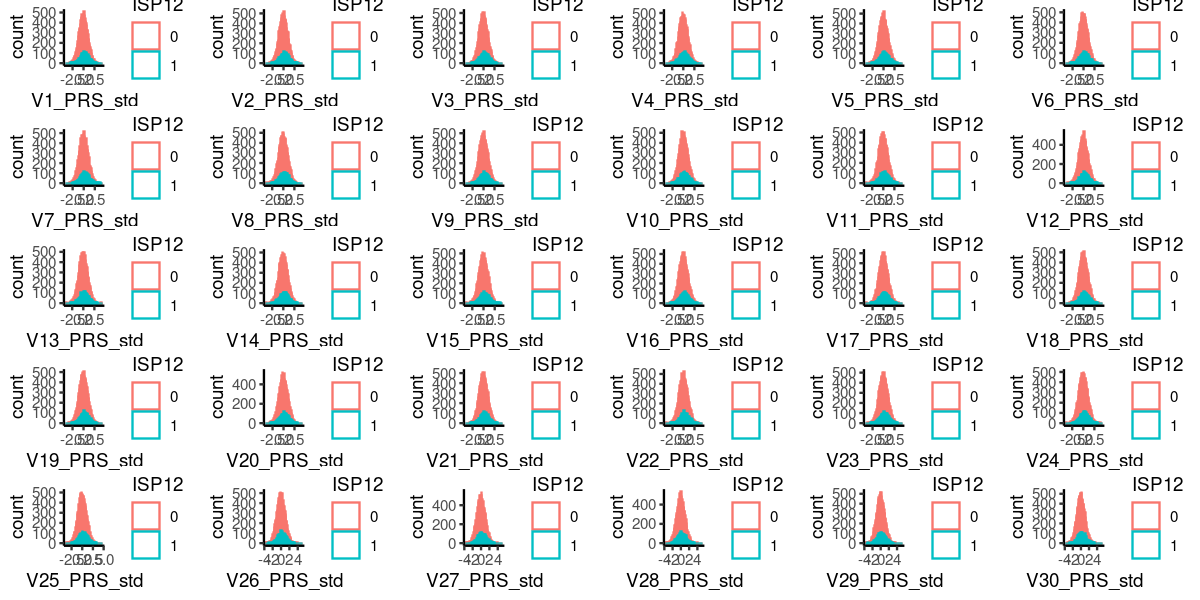

In [19]:
ggarrange(plotlist=plots)
ggsave('PRS_Plots.png', 
       device = 'png', 
       width = 30, 
       height = 25, 
       units = "in", 
       path = '~/Torkamani_Projects/20210712_Analysis-RegeniePaper/CAD_PRS/LDpred2/PRS_Calculated/',)

In [ ]:
V_names = glue::glue('V{i}_PRS_std',i=1:30)
logits = vector('list', 30)
coeffs = vector('list', 30)
errors = vector('list', 30)

for (i in 1:30) {
    logits[[i]] <- glm(formula(paste0("ISP12 ~", V_names[[i]])), data = data, family = binomial)
    summary <- summary(logits[[i]])
    coeffs[[i]] <- summary$coefficients[2,1]
    errors[[i]] <- summary$coefficients[2,2]
}

In [ ]:
logit_results <- data.frame(1:30, exp(as.numeric(coeffs)), exp(as.numeric(coeffs)) * as.numeric(errors))
names(logit_results) <- c('PRS_Score','Log_Odds','Error')

In [ ]:
plot <- ggplot(logit_results, aes(x = PRS_Score, y = Log_Odds)) + 
geom_point() + 
geom_errorbar(aes(ymin=Log_Odds-(1.96*Error), ymax=Log_Odds+(1.96*Error)), width=.5) +
theme_classic()
ggsave('Log_Odds_Plot.png', 
       device = 'png', 
       width = 5, 
       height = 5, 
       units = "in", 
       path = '~/Torkamani_Projects/20210712_Analysis-RegeniePaper/CAD_PRS/PRS_Calculated/',)

In [ ]:
plot

In [ ]:
logit_results[logit_results$Log_Odds == max(logit_results$Log_Odds),]

In [ ]:
offset = 34
V_names = glue::glue('V{i}_PRS_std',i=1:30)
i <- 21
plot <- ggplot(data, aes_string(V_names[[i]], color = 'ISP12')) + 
geom_vline(xintercept = 0, linetype = 'longdash') +
geom_vline(xintercept = mean(data[data$ISP12==0,i+34]), linetype = 'longdash', color = '#F8766D') +
geom_vline(xintercept = mean(data[data$ISP12==1,i+34]), linetype = 'longdash', color = '#00BFC4') +
geom_density(color = 'black') + 
geom_density() + 
theme_classic()
plot

In [ ]:
offset = 34
V_names = glue::glue('V{i}_PRS_std',i=1:30)
plots <- vector('list', 30)

for (i in 1:30) {
    plots[[i]] <- local({
        i <- i
        pred <- prediction(data[[i+offset]],data$ISP12)
        perf <- performance(pred,"sens","spec")

        perf_data <- data.frame(slot(perf,'x.values'), slot(perf,'y.values'))
        names(perf_data) <- c('Specificity','Sensitivity')

        plot <- ggplot(perf_data, aes(x = Specificity, y = Sensitivity)) + 
        geom_line() +
        ggtitle(paste0('V',i,' ROC Curve')) +
        geom_text(x = 0.4, y = 0.4, label = paste('AUC = ',performance(pred, measure = "auc")@y.values[[1]])) +
        coord_cartesian(xlim = c(1,0)) +
        theme_classic()


    })
}

In [ ]:
ggarrange(plots[[21]],plots[[30]])
ggsave('ROC_Plots.png',
       device = 'png', 
       width = 30, 
       height = 25, 
       units = "in", 
       path = '~/Torkamani_Projects/20210712_Analysis-RegeniePaper/CAD_PRS/PRS_Calculated/')

In [ ]:
for (i in 1:30) {
    data['cutoff'] <- as.factor(data[i + offset] > 0.842)
    colnames(data)[which(names(data) == "cutoff")] <- paste0('V',i,'_PRS_cutoff')
}

In [ ]:
head(data)

In [ ]:
data$ISP12 <- as.integer(data$ISP12)
res.cox <- coxph(Surv(AGISP12, ISP12) ~ V1_PRS_cutoff, data = data)
summary(res.cox)

In [ ]:
offset = 34
V_names = glue::glue('V{i}_PRS_cutoff',i=1:30)
plots <- vector('list', 30)

for (i in 1:30) {
    plots[[i]] <- local({
        i <- i
        sub_data <- data[c('AGISP12','ISP12',V_names[i])]
        names(sub_data) <- c('AGISP12','ISP12','cutoff')
        plots[[i]] <- ggsurvplot(survfit(Surv(AGISP12, ISP12) ~ cutoff, data = sub_data), data = sub_data, fun = "event")
    })
}

In [ ]:
arrange_ggsurvplots(list(plots[[21]],plots[[30]]), ncol = 2, nrow = 1)
ggsave('Cumulative_Risk_Plots.png',
       device = 'png', 
       width = 30, 
       height = 25, 
       units = "in", 
       path = '~/Torkamani_Projects/20210712_Analysis-RegeniePaper/CAD_PRS/PRS_Calculated/')

In [ ]:
head(data)

In [ ]:
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}
gg_color_hue(2)

In [ ]:
seq_log(1e-4, 0.9, 30)